# Importing Libraries

In [ ]:
!pip install tensorflow

# Reading and cleaning pipeline

# Building Model

# Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def read_data(path):
    dtype_dict = {
        'Station': 'string',
        'Air Dew Point': 'float',
        'Air Temperature (OC)': 'float',
        'Humidity %': 'float',
        'Atmospheric Pressure': 'float',
        'Liquid Precipitation': 'float',
        'Manual Present Weather …': 'string',
        'Cloud Type': 'string',
        'Clouds Cover (Okta)': 'float',
        'Cloud Cover %': 'float',
        'Snow Depth.depth In CM': 'float',
        'Horizontal Visibility In m.': 'float',
        'Wind Direction (Degrees)': 'float',
        'Wind Speed (MPS)': 'float',
        'Wind Type': 'string',
        'Wind Gust speed': 'float',
    }

    df = pd.read_excel(
        path,
        skiprows=5,
        dtype=dtype_dict,
        na_values=['Null', 'N/A', '--', 'sky obscured or cloud amount cannot be estimated']
    )

    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
    df.set_index('Date/Time', inplace=True)
    return df

def clean_data(df):
    columns_to_interpolate = [
        'Humidity %',
        'Air Dew Point',
        'Atmospheric Pressure',
        'Air Temperature (OC)',
        'Horizontal Visibility In m.',
        'Wind Direction (Degrees)',
        'Clouds Cover (Okta)',
        'Wind Speed (MPS)',
        'Cloud Cover %'
    ]
    for column in columns_to_interpolate:
        if column in df.columns:
            df[column] = df[column].interpolate(method='time')
    df['Liquid Precipitation'] = df['Liquid Precipitation'].fillna(0)
    return df

def prepare_data(df, features, sequence_length, forecast_length):
    scaler = StandardScaler()
    X_raw = df[features].values
    y_raw = df['Rain'].values

    X_scaled = scaler.fit_transform(X_raw)
    X, y = [], []
    for i in range(len(X_scaled) - sequence_length - forecast_length + 1):
        X.append(X_scaled[i:i + sequence_length])
        y.append(y_raw[i + sequence_length])
    return np.array(X), np.array(y), scaler


def create_complex_model(sequence_length, num_features, forecast_length, num_classes):
    input_layer = Input(shape=(sequence_length, num_features))

    cnn_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn_branch)
    cnn_branch = layers.BatchNormalization()(cnn_branch)  # Normalize
    cnn_branch = layers.GlobalAveragePooling1D()(cnn_branch)

    lstm_branch = layers.LSTM(128, activation='relu', return_sequences=True)(input_layer)
    lstm_branch = layers.Dropout(0.2)(lstm_branch)  # Regularization LSTM
    lstm_branch = layers.LSTM(64, activation='relu', return_sequences=False)(lstm_branch)

    attention_branch = layers.LSTM(128, activation='relu', return_sequences=True)(input_layer)
    attention_scores = layers.Attention()([attention_branch, attention_branch])
    attention_output = layers.GlobalAveragePooling1D()(attention_scores)
    combined = layers.Concatenate()([cnn_branch, lstm_branch, attention_output])

    dense = layers.Dense(256, activation='relu')(combined)
    dense = layers.Dropout(0.4)(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dense(128, activation='relu')(dense)
    dense = layers.Dropout(0.4)(dense)


    output = layers.Dense(1, activation='sigmoid')(dense)
    loss_function = 'binary_crossentropy'


    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy', 'Precision', 'Recall'])
    return model



In [ ]:
file_path = "/content/Aqaba Airport  01-07-1961 ---  30-05-2024.xlsx"
raw_data = read_data(file_path)
cleaned_data = clean_data(raw_data)

train_data = cleaned_data.loc['1961-01-01':'2010-12-31']
test_data = cleaned_data.loc['2011-01-01':]

<ipython-input-189-5a4f85bfcbc2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Rain'] = train_data['Liquid Precipitation'].apply(lambda x: 1 if x > 0 else 0)
<ipython-input-189-5a4f85bfcbc2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Rain'] = test_data['Liquid Precipitation'].apply(lambda x: 1 if x > 0 else 0)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - Precision: 0.0011 - Recall: 0.0169 - accuracy: 0.9664 - loss: 0.1063 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9968 - val_loss: 0.0512
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9970 - loss: 0.0206 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9968 - val_loss: 0.0196
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9972 - loss: 0.0176 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9968 - val_loss: 0.0186
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9973 - loss: 0.0176 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9968 - val_loss: 0.0183
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - Precision: 0.0000e+00 - Recall: 0.0

Model saved at: complex_weather_model.h5


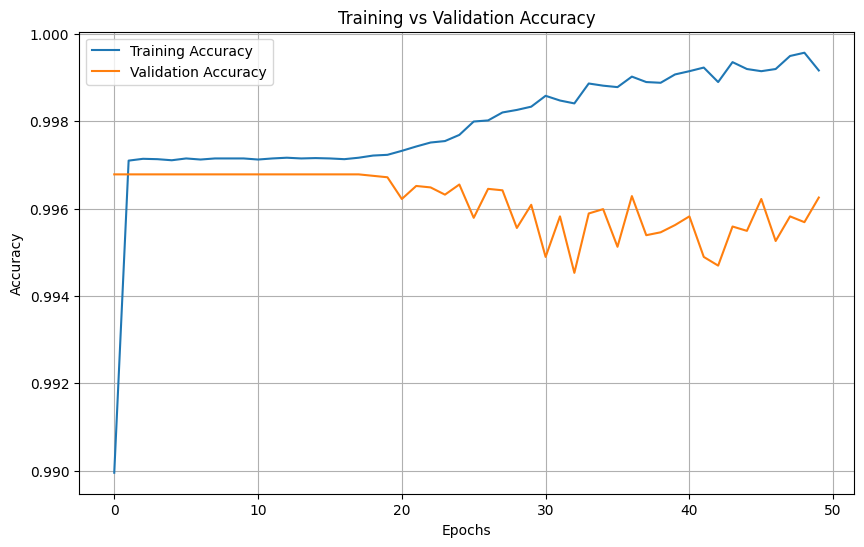

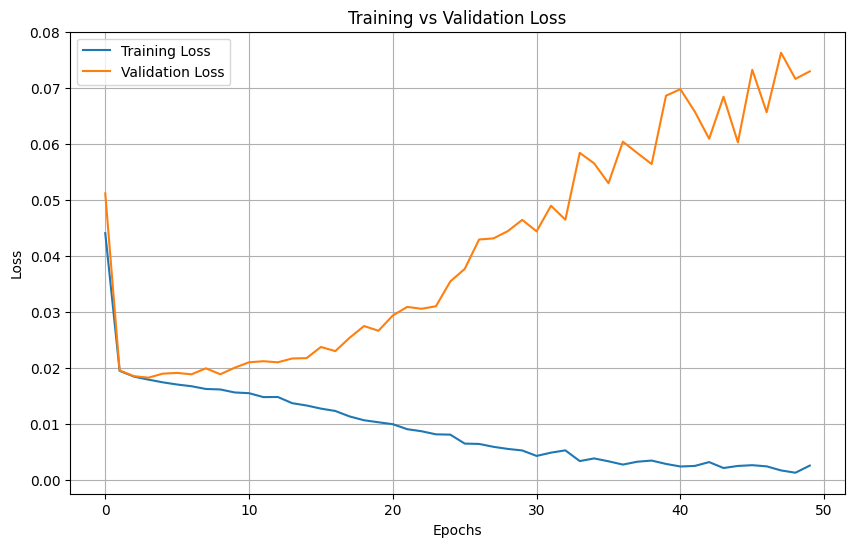

In [ ]:
train_data['Rain'] = train_data['Liquid Precipitation'].apply(lambda x: 1 if x > 0 else 0)
test_data['Rain'] = test_data['Liquid Precipitation'].apply(lambda x: 1 if x > 0 else 0)

features = [
    'Air Dew Point',
    'Air Temperature (OC)',
    'Humidity %',
    'Atmospheric Pressure',
    'Liquid Precipitation',
    'Cloud Cover %',
    'Horizontal Visibility In m.',
    'Wind Direction (Degrees)',
    'Wind Speed (MPS)'
]
sequence_length = 4
forecast_length = 1

X_train_raw, y_train_raw, scaler = prepare_data(train_data, features, sequence_length, forecast_length)
X_test, y_test_raw, _ = prepare_data(test_data, features, sequence_length, forecast_length)

X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)

num_features = len(features)
num_classes = 2

complex_model = create_complex_model(sequence_length, num_features, forecast_length, num_classes)

class_weights = {0: 1.0, 1: 1.0}

history = complex_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size = 1028,
    class_weight=class_weights
)

model_path = "complex_weather_model.h5"
complex_model.save(model_path)
print(f"Model saved at: {model_path}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


4014/4014 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step
Shape of y_pred_probs: (128426, 2)
Shape of y_pred_classes: (128426,)
Unique values in y_pred_classes: [0 1]
Shape of y_test_flat: (128426,)
Unique values in y_test_flat: [0 1]
Test Accuracy (2011 onward): 77.69%

Classification Report:
              precision    recall  f1-score   support

     No Rain       1.00      0.78      0.87    128192
        Rain       0.01      0.86      0.01       234

    accuracy                           0.78    128426
   macro avg       0.50      0.82      0.44    128426
weighted avg       1.00      0.78      0.87    128426



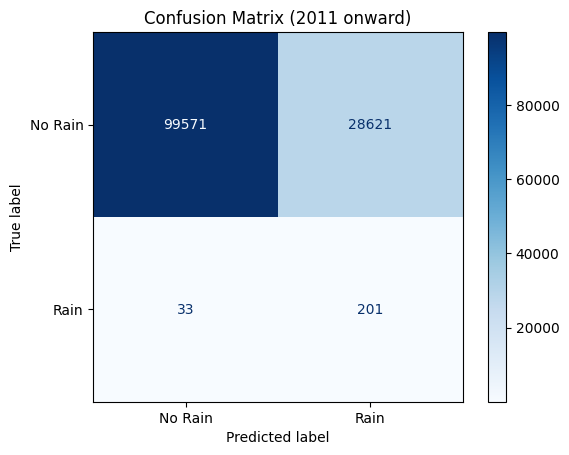

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_probs = trained_model.predict(X_test)

print(f"Shape of y_pred_probs: {y_pred_probs.shape}")

threshold = 0.01
if len(y_pred_probs.shape) == 2:
    rain_probs = y_pred_probs[:, 1]
else:
    rain_probs = y_pred_probs[:, :, 1].flatten()

y_pred_classes = (rain_probs >= threshold).astype(int)

y_test_flat = y_test_raw.flatten()

print(f"Shape of y_pred_classes: {y_pred_classes.shape}")
print(f"Unique values in y_pred_classes: {np.unique(y_pred_classes)}")
print(f"Shape of y_test_flat: {y_test_flat.shape}")
print(f"Unique values in y_test_flat: {np.unique(y_test_flat)}")

test_accuracy = np.mean(y_pred_classes == y_test_flat)
print(f"Test Accuracy (2011 onward): {test_accuracy:.2%}")

# Report
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_classes, target_names=["No Rain", "Rain"]))

conf_matrix = confusion_matrix(y_test_flat, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Rain", "Rain"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (2011 onward)")
plt.show()






# Step 7: Evaluate the Model (initial)
loss, accuracy = complex_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [ ]:
from sklearn.metrics import classification_report
y_pred_flat = np.argmax(trained_model.predict(X_test), axis=-1).flatten()
y_test_flat = np.argmax(y_test, axis=-1).flatten()

print(classification_report(y_test_flat, y_pred_flat, target_names=['No Rain', 'Rain']))


4014/4014 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step
              precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00    256382
        Rain       0.00      0.00      0.00       468

    accuracy                           1.00    256850
   macro avg       0.50      0.50      0.50    256850
weighted avg       1.00      1.00      1.00    256850



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
